In [68]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import mannwhitneyu
from scipy import stats

In [2]:
df_titanic = pd.read_csv("./data/titanic.csv")
df_housing = pd.read_csv("./data/ejemplo_housing.csv")
df_car = pd.read_csv("./data/car_price.csv")

### Funcion: tipifica_variables

Esta función debe recibir como argumento un dataframe, un entero (`umbral_categoria`) y un float (`umbral_continua`). La función debe devolver un dataframe con dos columnas "nombre_variable", "tipo_sugerido" que tendrá tantas filas como columnas el dataframe. En cada fila irá el nombre de una de las columnas y una sugerencia del tipo de variable. Esta sugerencia se hará siguiendo las siguientes pautas:
+ Si la cardinalidad es 2, asignara "Binaria"
+ Si la cardinalidad es menor que `umbral_categoria` asignara "Categórica"
+ Si la cardinalidad es mayor o igual que `umbral_categoria`, entonces entra en juego el tercer argumento:
    * Si además el porcentaje de cardinalidad es superior o igual a `umbral_continua`, asigna "Numerica Continua"
    * En caso contrario, asigna "Numerica Discreta"


In [3]:
def tipifica_variables(dataframe, umbral_categoria = int, umbral_continua = float):

    df_resultado = pd.DataFrame([dataframe.nunique(), dataframe.nunique()/len(dataframe)*100]).T.rename(columns = {0: "Cardinalidad", 1: "%_Cardinalidad"})
    
    df_resultado["Tipo"] = "Numérica Discreta"
    df_resultado.loc[df_resultado["Cardinalidad"] < umbral_categoria, "Tipo"] = "Categórica"
    df_resultado.loc[df_resultado["Cardinalidad"] == 2.0, "Tipo"] = "Binaria"
    df_resultado.loc[df_resultado["%_Cardinalidad"] >= umbral_continua, "Tipo"] = "Numérica Continua"

    return df_resultado

In [4]:
# prueba

tipifica_variables(df_titanic, 5, 25)

,Cardinalidad,%_Cardinalidad,Tipo
sex,2.0,0.224467,Binaria
age,89.0,9.988777,Numérica Discreta
sibsp,7.0,0.785634,Numérica Discreta
parch,7.0,0.785634,Numérica Discreta
fare,248.0,27.833895,Numérica Continua
class,3.0,0.336700,Categórica
who,3.0,0.336700,Categórica
adult_male,2.0,0.224467,Binaria
embark_town,3.0,0.336700,Categórica
alive,2.0,0.224467,Binaria


### Funcion: get_features_cat_regression

Esta función recibe como argumentos un dataframe, el nombre de una de las columnas del mismo (argumento 'target_col'), que debería ser el target de un hipotético modelo de regresión, es decir debe ser una variable numérica continua o discreta pero con alta cardinalidad y una variable float "pvalue" cuyo valor por defecto será 0.05.

La función debe devolver una lista con las columnas categóricas del dataframe cuyo test de relación con la columna designada por 'target_col' supere en confianza estadística el test de relación que sea necesario hacer (es decir la función debe poder escoger cuál de los dos test que hemos aprendido tiene que hacer).

La función debe hacer todas las comprobaciones necesarias para no dar error como consecuecia de los valores de entrada. Es decir hará un check de los valores asignados a los argumentos de entrada y si estos no son adecuados debe retornar None y printar por pantalla la razón de este comportamiento. Ojo entre las comprobaciones debe estar que "target_col" hace referencia a una variable numérica continua del dataframe.


[PENDING] Try and except ---> evaluar los valores asignados a los argumentos de entrada y retornar 'None' con el error correspondiente.

[CHECK!!] Llamar a la función cardinalidad para que nos tipifique las columnas del dataset y guardar las categóricas en una variable

[CHECK!!] Poner inputs para que el usuario establezca los umbrales requeridos en los argumentos de la cardinalidad

[CHECK] Análisis un bivariante de las categóricas contra la target, medir ratios y frecuencias 

[CHECK] Análisis bivariante numérica (target) vs categórica (lista de categóricas) mediante test de hipótesis U de Mann-Whitney & ANOVA

[CHECK] Que distinga cuál de los dos tests debe aplicar: U de Mann-Whitney --> Binarias   ///  ANOVA --> resto de categóricas

[CHECK] Return --> lista de variables que superen en confianza estadística el test de relación pertinente

In [21]:
def check_parametros(df, target_col, umbral_corr = 0, umbral_categoria = 0, umbral_continua = 0, pvalue = None):
    if not isinstance(df, pd.DataFrame):
        print("Error: el primer argumento debe ser un DataFrame.")
        return None

    if target_col not in df.columns:
        print(f"Error: la columna '{target_col}' no existe en el DataFrame.")
        return None

    if not np.issubdtype(df[target_col].dtype, np.number):
        print(f"Error: la columna '{target_col}' no es numérica.")
        return None

    if df[target_col].nunique() < 10:
        print(f"Error: '{target_col}' no parece ser una variable continua (baja cardinalidad).")
        return None

    if not (0 <= umbral_corr <= 1):
        print("Error: 'umbral_corr' debe estar entre 0 y 1.")
        return None

    if type(umbral_categoria) != int or umbral_categoria < 0:
        print("Error: 'umbral_categoria' debe ser un número entero.")
        return None

    if type(umbral_continua) != float or umbral_continua < 0:
        print("Error: 'umbral_continua' debe ser un número decimal.")
        return None

    if pvalue is not None:
        if not isinstance(pvalue, (float, int)) or not (0 < pvalue < 1):
            print("Error: 'pvalue' debe ser un número entre 0 y 1 o None.")
            return None
    return 'OK'

In [28]:
def get_features_cat_regression(dataframe:pd.DataFrame, target_col:float, pvalue = 0.05, umbral_categoria = 6, umbral_continua = 25.0): 
    
    """
    DESCRIPCIÓN:

    Análisis bivariante de la variable target contra las variables categóricas de un dataset para su posterior selección de features categóricas ante la construcción de un 
    hipotético modelo de regresión lineal.

    REQUISITOS:
    
    Es necesario importar mannwhitneyu y stats de scipy, ejecuta:
    
    from scipy.stats import mannwhitneyu 
    
    from scipy import stats

    ARGUMENTOS:

    param1 (DataFrame): Dataset de train del conjunto de datos de un hipotético modelo de regresión lineal que queremos entrenar

    param2 (float): Columna del dataset que constiuye el 'target' de nuestro hipotético modelo de regresión. Variable numérica continua o discreta con alta cardinalidad

    param3 (float): Valor del pvalue (default = 0.05) 

    RETURN:

    (list): Variables categóricas que superen en confianza estadística el test de relación pertinente tras un análisis bivariante.

    """
    if check_parametros(dataframe, target_col, umbral_categoria = umbral_categoria, umbral_continua = umbral_continua, pvalue=pvalue) != 'OK':
        return None

    df_tipo = tipifica_variables(dataframe, umbral_categoria, umbral_continua)

    # me quedo con las categóricas y las vuelco en una lista el nombre de la variable, que está en el índice del dataset
    
    es_catego = df_tipo.Tipo == "Categórica"
    es_binaria = df_tipo.Tipo == "Binaria"

    lista_categoricas = df_tipo.loc[es_catego | es_binaria].index.to_list()

    features_categoricas = []
    for categoria in lista_categoricas:
        # si mi variable es binaria, aplicamos U de Mann-Whitney

        if len(dataframe[categoria].unique()) == 2:      
            
            # from scipy.stats import mannwhitneyu --> preguntar si esto debería ir aquí o añadir en el stringdoc que es necesario importarlo para usar la función
            
            es_a = dataframe[categoria].unique()[0]   # obtengo las dos agrupaciones
            es_b = dataframe[categoria].unique()[1]
            
            grupo_a = dataframe.loc[dataframe[categoria] == es_a][target_col]   # y separo mi dataset en función de ellas
            grupo_b = dataframe.loc[dataframe[categoria] == es_b][target_col]
            
            u_stat, p_valor = mannwhitneyu(grupo_a, grupo_b)

            if p_valor <= pvalue:
                features_categoricas.append(categoria)
            

        # si no es binaria, aplicamos ANOVA

        else:   
            # from scipy import stats 
            grupos = dataframe[categoria].unique()  # obtengo todos valores de la variable

            # obtenemos los valores del target por cada valor de las diferentes categorias con un list comprehension 
            argumento_stats = [dataframe[dataframe[categoria] == grupo][target_col] for grupo in grupos] 
                 
            f_val, p_valor = stats.f_oneway(*argumento_stats) # El método * separa todos los elementos de la lista y los pasa como argumento a la función                                                   

            if p_valor <= pvalue:
                features_categoricas.append(categoria)

    return features_categoricas  


In [7]:
df_titanic.alive = df_titanic.alive.replace('yes',1).replace('no',0)

/tmp/ipykernel_21035/1070032544.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_titanic.alive = df_titanic.alive.replace('yes',1).replace('no',0)


In [22]:
get_features_cat_regression(df_titanic, "alive")

Error: 'alive' no parece ser una variable continua (baja cardinalidad).


In [29]:
get_features_cat_regression(df_housing, "median_house_value")

['ocean_proximity']

In [30]:
get_features_cat_regression(df_car, "price", pvalue=0.05)

['fueltype', 'aspiration', 'carbody', 'drivewheel', 'enginelocation']

In [31]:
df_car.columns

Index(['car_ID', 'symboling', 'CarName', 'fueltype', 'aspiration',
       'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'wheelbase',
       'carlength', 'carwidth', 'carheight', 'curbweight', 'enginetype',
       'cylindernumber', 'enginesize', 'fuelsystem', 'boreratio', 'stroke',
       'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg',
       'price'],
      dtype='object')

### plot_features_cat_regression

Esta función recibe un dataframe, una argumento "target_col" con valor por defecto "", una lista de strings ("columns") cuyo valor por defecto es la lista vacía, un argumento ("pvalue") con valor 0.05 por defecto y un argumento "with_individual_plot" a False.

Si la lista no está vacía, la función pintará los histogramas agrupados de la variable "target_col" para cada uno de los valores de las variables categóricas incluidas en columns que cumplan que su test de relación con "target_col" es significatio para el nivel 1-pvalue de significación estadística. La función devolverá los valores de "columns" que cumplan con las condiciones anteriores. 

Si la lista está vacía, entonces la función igualará "columns" a las variables numéricas del dataframe y se comportará como se describe en el párrafo anterior.

De igual manera que en la función descrita anteriormente deberá hacer un check de los valores de entrada y comportarse como se describe en el último párrafo de la función `get_features_cat_regression`.

In [118]:
def plot_features_cat_regression(df, target_col = '', columns=[], pvalue=0.05, with_individual_plot=False, umbral_categoria = 6, umbral_continua = 25.0, escala_log=False):

    if check_parametros(df, target_col, umbral_categoria = umbral_categoria, umbral_continua = umbral_continua, pvalue=pvalue) != 'OK':
        return None

    if len(columns) == 0:
        columns = [variable for variable in df.columns if not np.issubdtype(df[variable].dtype, np.number)]
    
    columns.append(target_col)
    columnas = get_features_cat_regression(df[columns], target_col=target_col, pvalue=pvalue, umbral_categoria = 6, umbral_continua = 25.0)
    
    fig, ax = plt.subplots(len(columnas), figsize=(10,10))
    for index, columna in enumerate(columnas):
        sns.histplot(df, x=target_col, hue=columna, ax=ax[index], log_scale=escala_log)

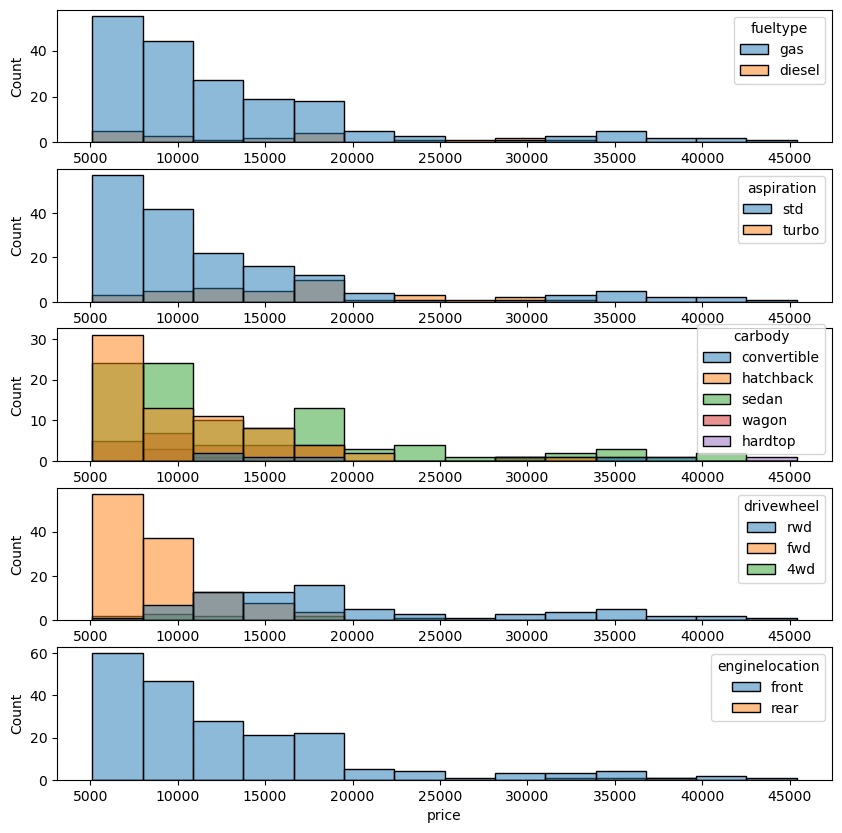

In [121]:
plot_features_cat_regression(df_car, target_col="price", pvalue=0.05)